# Preparing the data

## Imports

In [1]:
# Importing libraries

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import re

import cv2

from skimage.measure import shannon_entropy

In [2]:
# Importing our own modules

import sys

sys.path.insert(0, '/Users/manu/Desktop/ML_Projects/DoctorPy')

from utils.preprocessing import resize_img, thresh_inf, edge_brightness

## Data loading

In [3]:
covid_path = '../data/COVID-19/'
covid_files = [covid_path + file for file in os.listdir(covid_path) if file[-3:] == 'png']

normal_path = '../data/NORMAL/'
normal_files = [normal_path + file for file in os.listdir(normal_path) if file[-3:] == 'png']

vp_path = '../data/Viral Pneumonia/'
vp_files = [vp_path + file for file in os.listdir(vp_path) if file[-3:] == 'png']

# Each variable contains the path to the associated images

## Displaying some random images

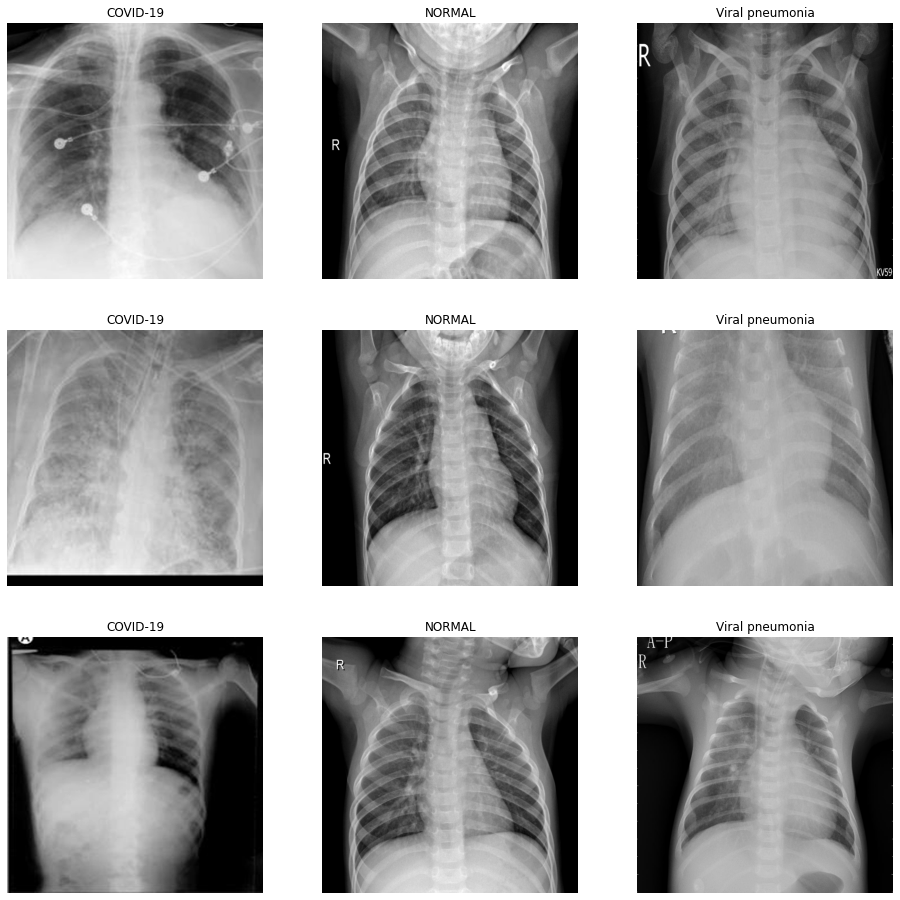

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(16,16))


for i in range(3):
    ax.flat[3*i].imshow(cv2.imread(np.random.choice(covid_files), cv2.IMREAD_GRAYSCALE), cmap='gray')
    ax.flat[3*i].axis('off')
    ax.flat[3*i].set_title('COVID-19')

    ax.flat[3*i+1].imshow(cv2.imread(np.random.choice(normal_files), cv2.IMREAD_GRAYSCALE), cmap='gray')
    ax.flat[3*i+1].axis('off')
    ax.flat[3*i+1].set_title('NORMAL')
  
    ax.flat[3*i+2].imshow(cv2.imread(np.random.choice(vp_files), cv2.IMREAD_GRAYSCALE), cmap='gray')
    ax.flat[3*i+2].axis('off')
    ax.flat[3*i+2].set_title('Viral pneumonia')

Note that the COVID-19 images seem to stand out in various ways.<br>
The zoom differs on some of those images, the contrast is lower and you may find cables or tubes.

## Storing the dataset in arrays

In [5]:
# We will simply resize the images and store them in arrays to be able to study them

# Creating a dataset of the images without any other preprocessing than a simple resizing

size = (256, 256)

# Creating the arrays

d_c = np.zeros((len(covid_files), 256, 256))
d_n = np.zeros((len(normal_files), 256, 256))
d_vp = np.zeros((len(vp_files), 256, 256))

# Filling the arrays

for i in range(len(d_c)):
    d_c[i] = resize_img(cv2.imread(covid_files[i], cv2.IMREAD_GRAYSCALE), size)
for i in range(len(d_n)):
    d_n[i] = resize_img(cv2.imread(normal_files[i], cv2.IMREAD_GRAYSCALE), size)
for i in range(len(d_vp)):
    d_vp[i] = resize_img(cv2.imread(vp_files[i], cv2.IMREAD_GRAYSCALE), size)

In [6]:
images = np.concatenate([d_c, d_n, d_vp], axis=0)

In [7]:
df_c = pd.DataFrame({'path': covid_files})
df_c['image'] = df_c['path'].apply(lambda x: re.split(r'[\(\)]', x)[1]).astype('int')
df_c = df_c.sort_values('image')
df_c = df_c.reset_index(drop=True)
df_c['label'] = 'COVID-19'


df_n = pd.DataFrame({'path': normal_files})
df_n['image'] = df_n['path'].apply(lambda x: re.split(r'[\(\)]', x)[1]).astype('int')
df_n = df_n.sort_values('image')
df_n = df_n.reset_index(drop=True)
df_n['label'] = 'NORMAL'

df_vp = pd.DataFrame({'path': vp_files})
df_vp['image'] = df_vp['path'].apply(lambda x: re.split(r'[\(\)]', x)[1]).astype('int')
df_vp = df_vp.sort_values('image')
df_vp = df_vp.reset_index(drop=True)
df_vp['label'] = 'Viral Pneumonia'

df = pd.concat([df_c, df_n, df_vp], ignore_index = True)

df

,path,image,label
0,../data/COVID-19/COVID-19 (1).png,1,COVID-19
1,../data/COVID-19/COVID-19 (2).png,2,COVID-19
2,../data/COVID-19/COVID-19 (3).png,3,COVID-19
3,../data/COVID-19/COVID-19 (4).png,4,COVID-19
4,../data/COVID-19/COVID-19 (5).png,5,COVID-19
...,...,...,...
3825,../data/Viral Pneumonia/Viral Pneumonia (1341)...,1341,Viral Pneumonia
3826,../data/Viral Pneumonia/Viral Pneumonia (1342)...,1342,Viral Pneumonia
3827,../data/Viral Pneumonia/Viral Pneumonia (1343)...,1343,Viral Pneumonia
3828,../data/Viral Pneumonia/Viral Pneumonia (1344)...,1344,Viral Pneumonia


# Data exploration

## Average image per label

In [8]:
avg_c = np.mean(d_c, axis=0)
avg_n = np.mean(d_n, axis=0)
avg_vp = np.mean(d_vp, axis=0)

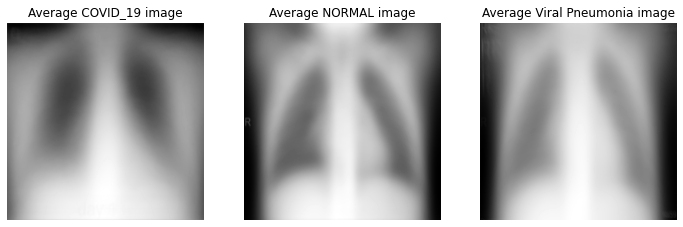

In [9]:
plt.figure(figsize=(12,6))

plt.subplot(131)
plt.imshow(avg_c, cmap='gray')
plt.title('Average COVID_19 image')
plt.axis('off')

plt.subplot(132)
plt.imshow(avg_n, cmap='gray')
plt.title('Average NORMAL image')
plt.axis('off')

plt.subplot(133)
plt.imshow(avg_vp, cmap='gray')
plt.title('Average Viral Pneumonia image')
plt.axis('off');

While there are some differences between the `NORMAL` and `Viral Pneumonia` classes, the one that stands out the most the `COVID-19` class. It seems the lungs are darker, of a different shape and the image looks like it was zoomed in. 

## Average pixel intensity

In [10]:
df['mean'] = [img.mean() for img in images]

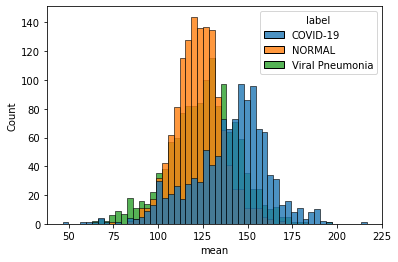

In [11]:
sns.histplot(data=df, x='mean', hue='label', alpha=0.8);

The `COVID-19` images are brighter overall, which could be explained by the zoom factor, since the bones would be larger, and their range is also larger.<br>
The `NORMAL` class is the most homogenous, though it doesn't differ much from the `Viral Pneumonia` class.

## Pixel intensity standard deviation

In [12]:
df['std'] = [img.std() for img in images]

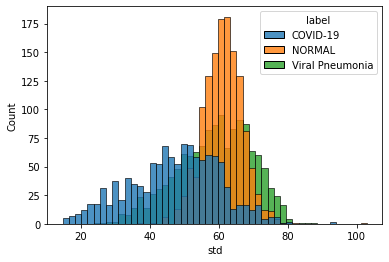

In [13]:
sns.histplot(data=df, x='std', hue='label', alpha=0.8);

The standard deviation of pixel intensity gives an indication of the contrast of an image.<br>
Once again, the class that stands out the most is the `COVID-19` class, with very spread out but low values.

## Intensity thresholds

In [14]:
df['thresh_inf_50'] = [thresh_inf(img) for img in images]

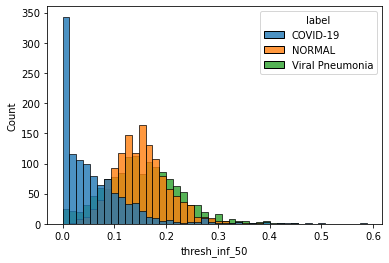

In [15]:
sns.histplot(data=df, x='thresh_inf_50', hue='label', alpha=0.8);

When studying the amount of pixels below a certain threshold, in this case 50, the `COVID-19` class stands out even more. This means that those images have very few black or dark gray images. Once again, the zoom factor could explain this, coupled with the low contrast of the images. 

## Entropy

In [16]:
df['entropy'] = [shannon_entropy(images[i]) for i in range(len(df))]

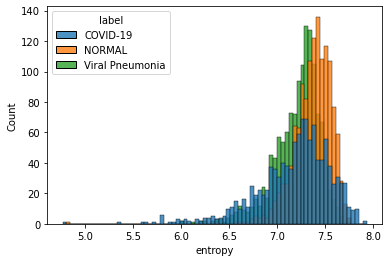

In [17]:
sns.histplot(data=df, x='entropy', hue='label', alpha=0.8);

In the case of the entropy, it seems that the difference between the classes is less obvious.

## Edge intensity

In [18]:
df['edge_brightness'] = [edge_brightness(img)[0] for img in images]

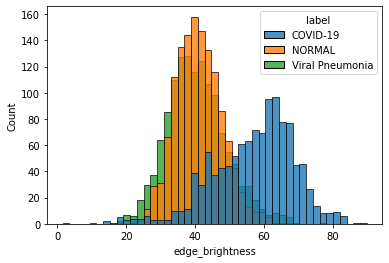

In [19]:
sns.histplot(data=df, x='edge_brightness', hue='label', alpha=0.8);

Here we have another case where the `COVID-19` class stands out while the other two are pretty alike. This one could very clearly be explained by the zoom factor, as the zoomed images would have brighter edges.

# Statistical tests

We now need to investigate statistically the correlation between each feature that we have extracted and the classes.<br>
With this goal in mind, we will use an ANOVA statistical test.

In [20]:
def statistical_test(df, var, target='label', p=0.05):

    test = var + ' ~ ' + target
    result = sm.formula.ols(test, data = df).fit()
    table = sm.stats.anova_lm(result)
    p_value = table['PR(>F)'][target]
  
    print('The ANOVA test with the {} variable produces a p value of {}.'.format(var, p_value))

    if p_value < p:
        print('We can thus reject the hypthesis that the label has no influence on the mean of the {} variable.'.format(p, var))

    else:
        print('We can thus not reject the hypthesis that the label has no influence on the mean of the {} variable.'.format(p, var))


In [21]:
tests_var = ['mean', 'std', 'thresh_inf_50', 'entropy', 'edge_brightness'] 

for var in tests_var:
    statistical_test(df, var)
    print('\n')

The ANOVA test with the mean variable produces a p value of 7.321199153804988e-135.
We can thus reject the hypthesis that the label has no influence on the mean of the 0.05 variable.


The ANOVA test with the std variable produces a p value of 3.4280190256877647e-247.
We can thus reject the hypthesis that the label has no influence on the mean of the 0.05 variable.


The ANOVA test with the thresh_inf_50 variable produces a p value of 1.3422005691730223e-292.
We can thus reject the hypthesis that the label has no influence on the mean of the 0.05 variable.


The ANOVA test with the entropy variable produces a p value of 1.802313942704406e-75.
We can thus reject the hypthesis that the label has no influence on the mean of the 0.05 variable.


The ANOVA test with the edge_brightness variable produces a p value of 0.0.
We can thus reject the hypthesis that the label has no influence on the mean of the 0.05 variable.




In [25]:
# df.to_csv('../data/eda_df.csv')

# Conclusion

It would appear that this dataset is very biased. Simple statistical tools, even just visualizations, are enough to distinguish the classes in certain cases. We will need to investigate those biases.